# Cat Sound Mood Classification - EDA

Exploring the audio dataset to understand class distribution, audio characteristics, and sample visualizations.


In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Audio, display

DATA_DIR = Path("../data/raw")
plt.style.use('seaborn-v0_8-darkgrid')


## 1. Dataset Overview


In [2]:
# Get all categories and their file counts
categories = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
file_counts = {cat: len(list((DATA_DIR / cat).glob("*.mp3"))) for cat in categories}

print(f"Number of categories: {len(categories)}")
print(f"Total samples: {sum(file_counts.values())}")
print("\nCategories:")
for cat, count in file_counts.items():
    print(f"  {cat}: {count} files")


Number of categories: 10
Total samples: 100

Categories:
  Angry: 10 files
  Defense: 10 files
  Fighting: 10 files
  Happy: 10 files
  HuntingMind: 10 files
  Mating: 10 files
  MotherCall: 10 files
  Paining: 10 files
  Resting: 10 files


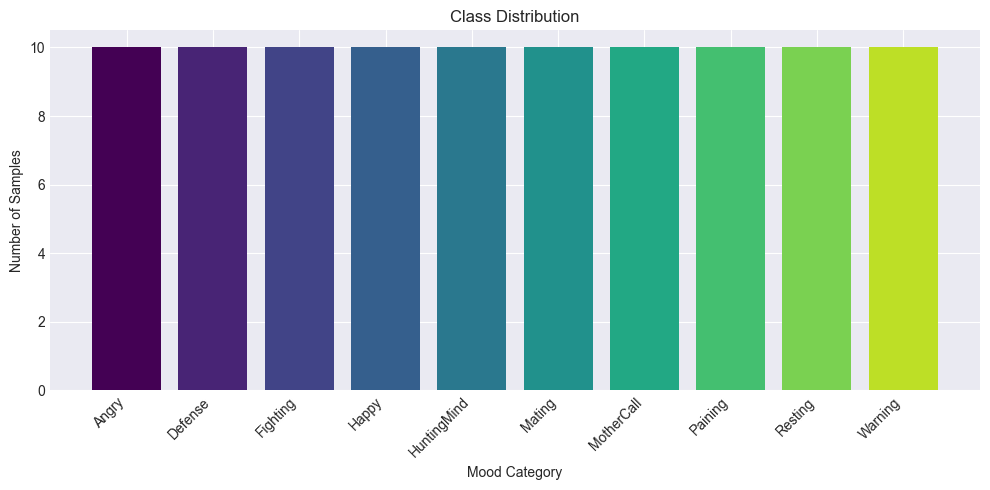

In [3]:
# Class distribution bar chart
fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 0.9, len(categories)))
bars = ax.bar(file_counts.keys(), file_counts.values(), color=colors)
ax.set_xlabel("Mood Category")
ax.set_ylabel("Number of Samples")
ax.set_title("Class Distribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 2. Audio Duration Analysis


In [7]:
# Collect duration info for all files
durations = []
sample_rates = []

for cat in categories:
    for audio_file in (DATA_DIR / cat).glob("*.mp3"):
        try:
            y, sr = librosa.load(audio_file, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            durations.append({"category": cat, "duration": duration, "file": audio_file.name})
            sample_rates.append(sr)
        except Exception as e:
            print(f"Error loading {audio_file}: {e}")

print(f"Loaded {len(durations)} audio files")
print(f"Sample rates found: {set(sample_rates)}")


Loaded 100 audio files
Sample rates found: {44100}


In [8]:
# Duration statistics
all_durations = [d["duration"] for d in durations]
print(f"Duration stats (seconds):")
print(f"  Min: {min(all_durations):.2f}s")
print(f"  Max: {max(all_durations):.2f}s")
print(f"  Mean: {np.mean(all_durations):.2f}s")
print(f"  Median: {np.median(all_durations):.2f}s")


Duration stats (seconds):
  Min: 0.95s
  Max: 8.49s
  Mean: 3.57s
  Median: 3.45s


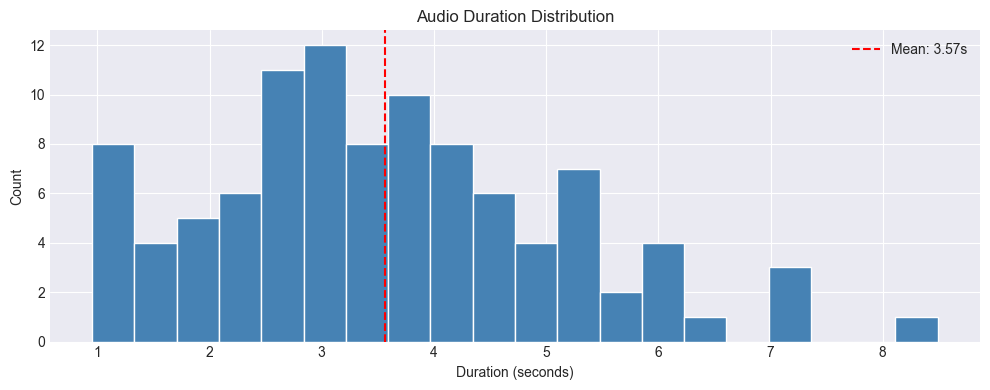

In [9]:
# Duration distribution histogram
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(all_durations, bins=20, color='steelblue', edgecolor='white')
ax.axvline(np.mean(all_durations), color='red', linestyle='--', label=f'Mean: {np.mean(all_durations):.2f}s')
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Count")
ax.set_title("Audio Duration Distribution")
ax.legend()
plt.tight_layout()
plt.show()


/var/folders/10/k5jsszhx3wz9pfq1f8lcn8jc0000gn/T/ipykernel_17487/2768936751.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(duration_by_cat, labels=categories, patch_artist=True)


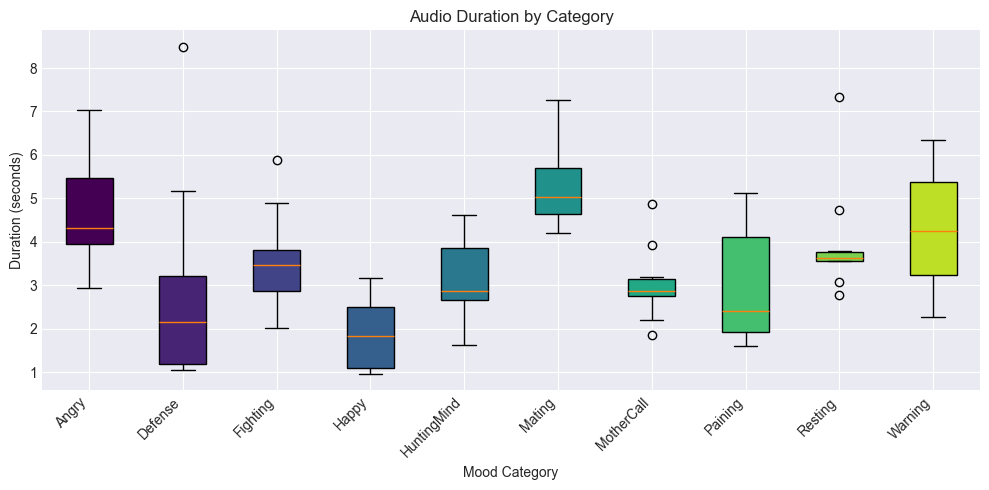

In [10]:
# Duration by category (boxplot)
fig, ax = plt.subplots(figsize=(10, 5))
duration_by_cat = [[d["duration"] for d in durations if d["category"] == cat] for cat in categories]
bp = ax.boxplot(duration_by_cat, labels=categories, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xlabel("Mood Category")
ax.set_ylabel("Duration (seconds)")
ax.set_title("Audio Duration by Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 3. Sample Audio Visualization

Let's look at one sample from each category to understand the audio characteristics.


In [11]:
def visualize_audio(audio_path, title):
    """Display waveform, spectrogram, and mel spectrogram for an audio file."""
    y, sr = librosa.load(audio_path, sr=22050)
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 3))
    
    # Waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[0])
    axes[0].set_title("Waveform")
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title("Spectrogram")
    
    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[2])
    axes[2].set_title("Mel Spectrogram")
    
    fig.suptitle(title, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Play audio
    display(Audio(y, rate=sr))


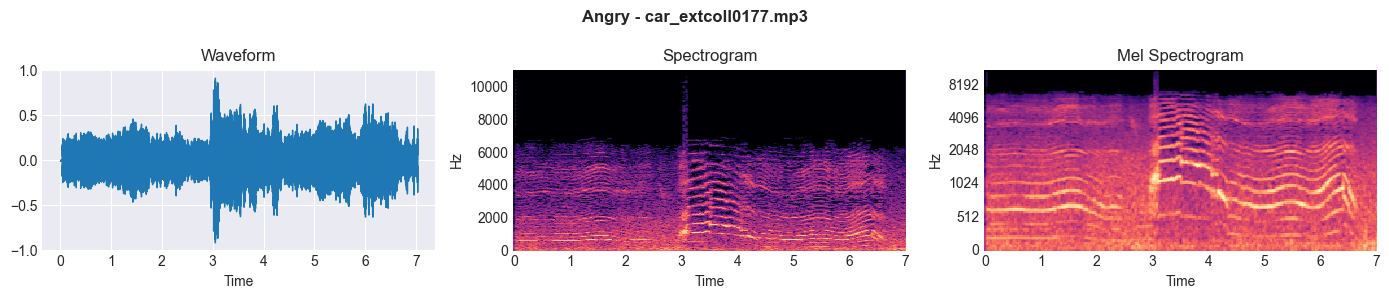

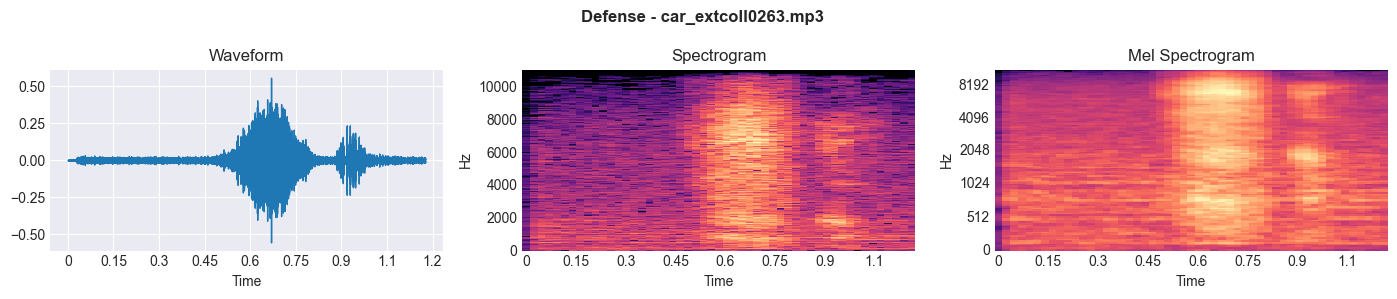

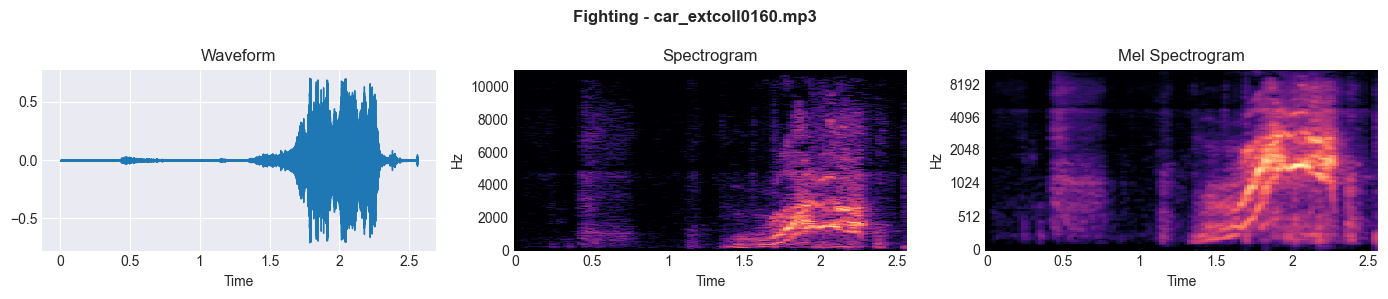

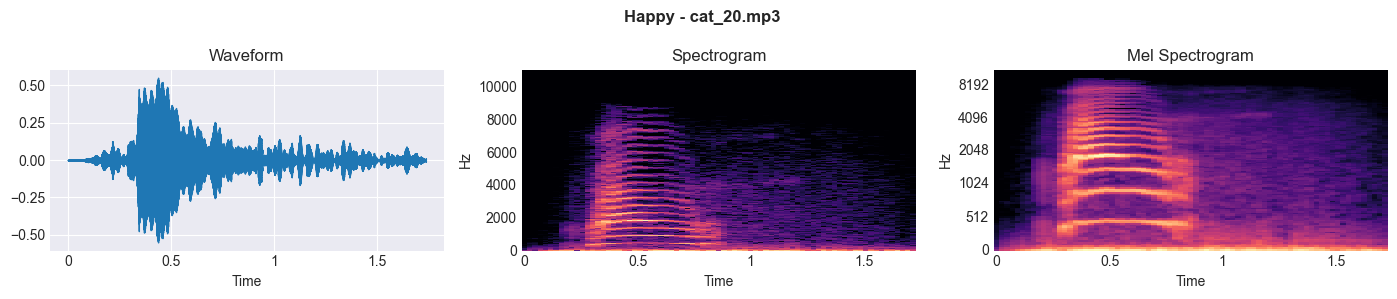

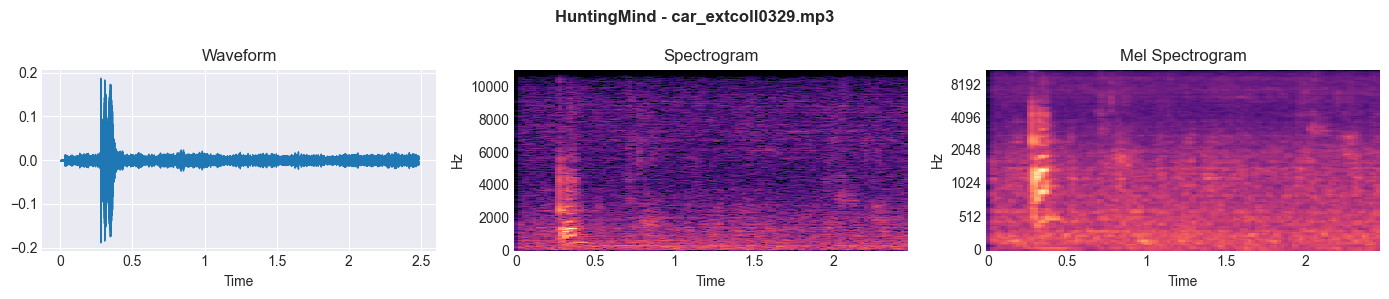

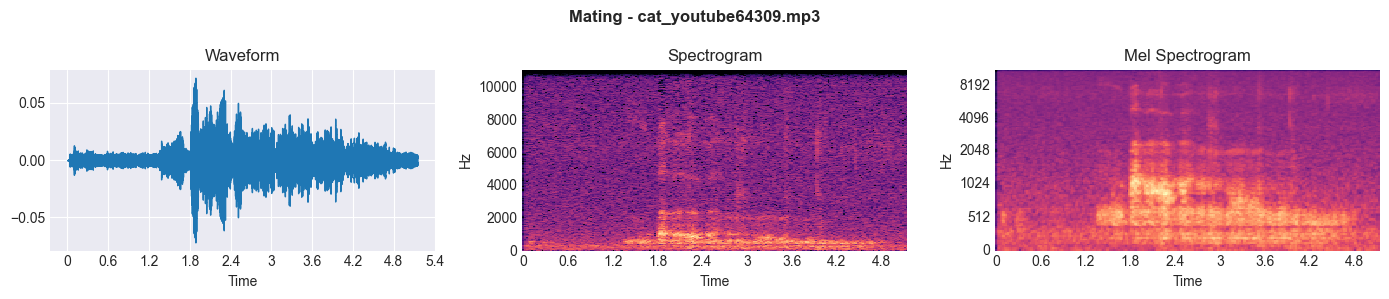

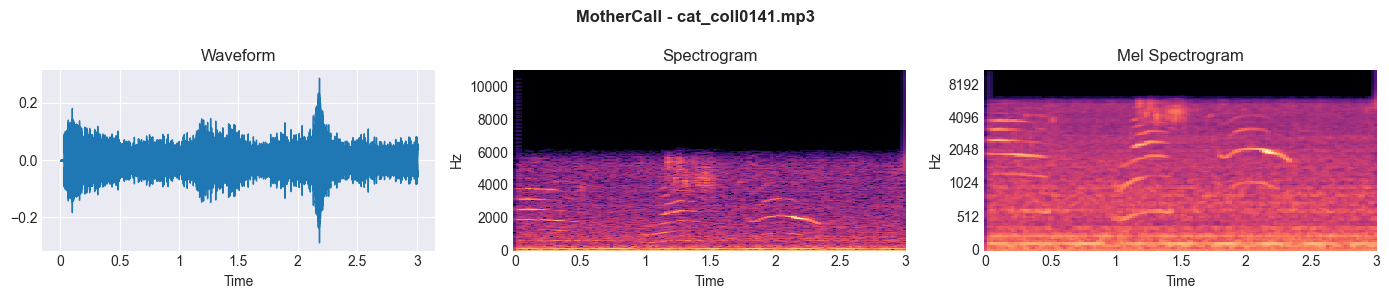

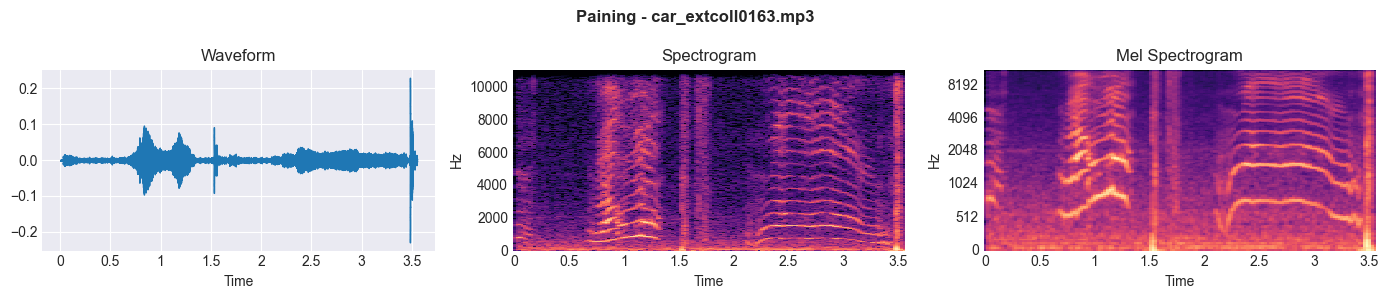

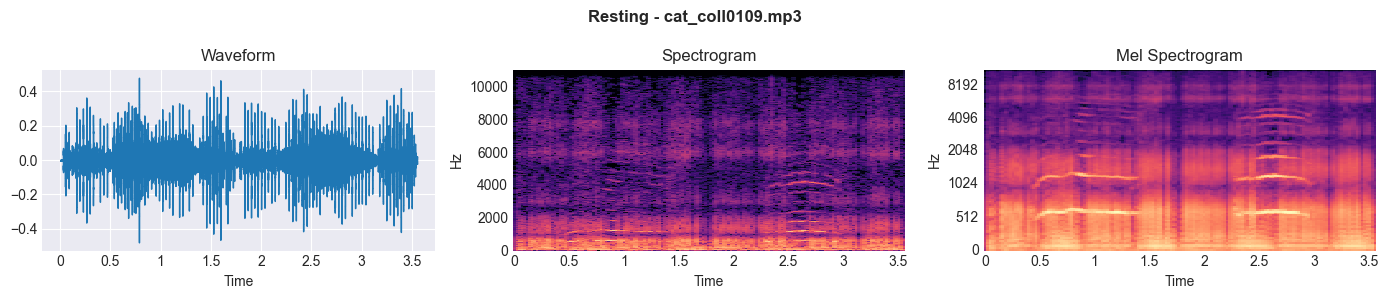

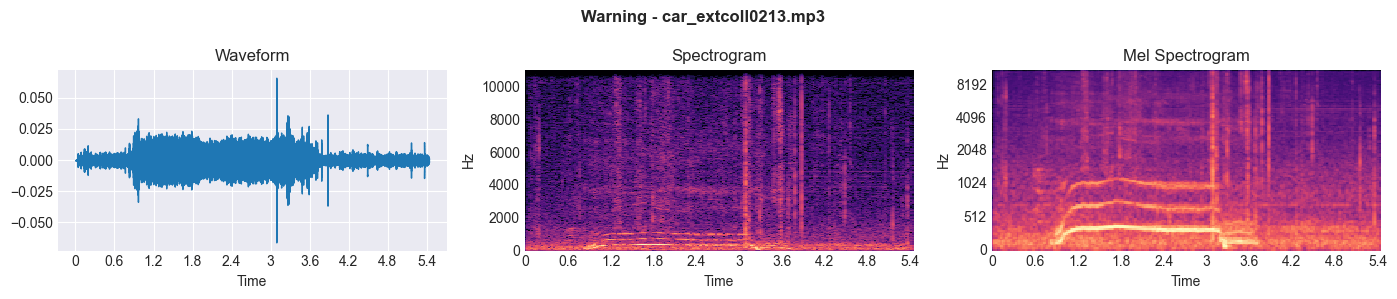

In [12]:
# Visualize one sample from each category
for cat in categories:
    sample_file = next((DATA_DIR / cat).glob("*.mp3"))
    visualize_audio(sample_file, f"{cat} - {sample_file.name}")


## 4. Feature Analysis (MFCCs)

Quick look at MFCC distributions across categories - a common feature for audio classification.


In [13]:
# Extract mean MFCCs for each file
mfcc_data = []

for cat in categories:
    for audio_file in (DATA_DIR / cat).glob("*.mp3"):
        try:
            y, sr = librosa.load(audio_file, sr=22050)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_mean = np.mean(mfcc, axis=1)
            mfcc_data.append({"category": cat, "mfcc": mfcc_mean})
        except:
            pass

print(f"Extracted MFCCs from {len(mfcc_data)} files")


Extracted MFCCs from 100 files


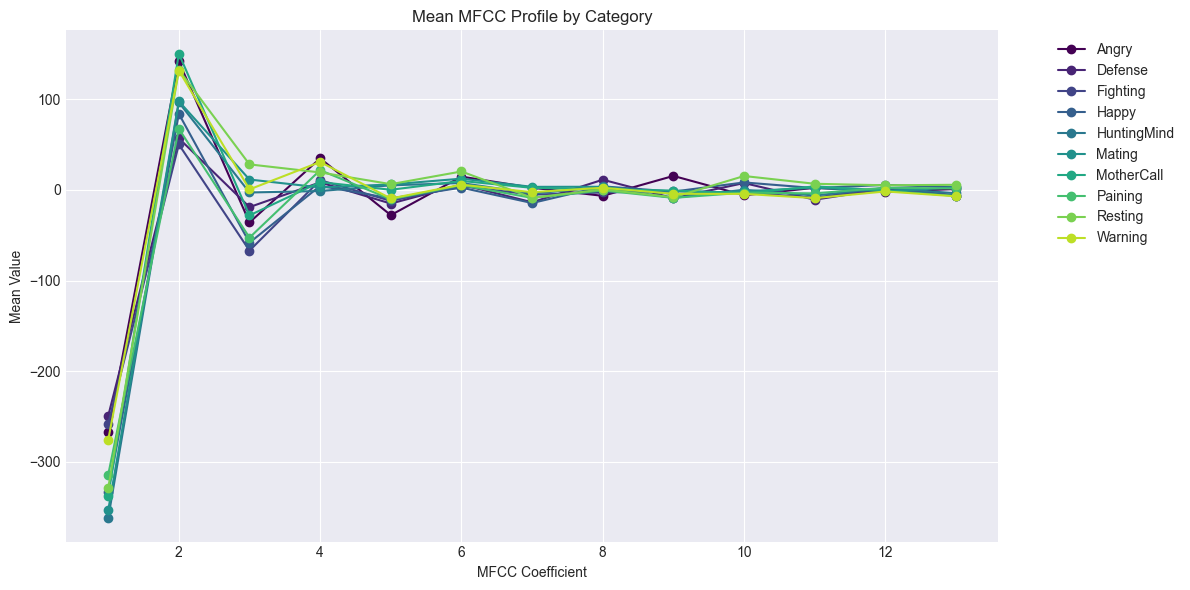

In [14]:
# Plot mean MFCC profile by category
fig, ax = plt.subplots(figsize=(12, 6))

for i, cat in enumerate(categories):
    cat_mfccs = np.array([d["mfcc"] for d in mfcc_data if d["category"] == cat])
    mean_mfcc = np.mean(cat_mfccs, axis=0)
    ax.plot(range(1, 14), mean_mfcc, marker='o', label=cat, color=colors[i])

ax.set_xlabel("MFCC Coefficient")
ax.set_ylabel("Mean Value")
ax.set_title("Mean MFCC Profile by Category")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Look at the cosine similarities of each binary class combinations to see which ones can we merge under one class

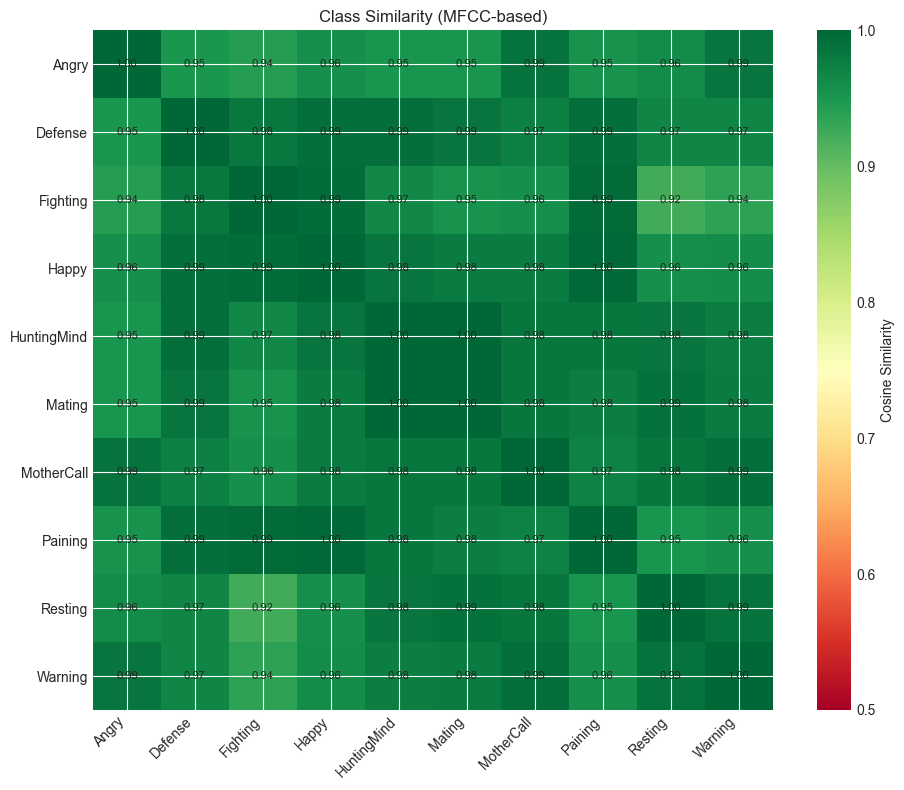

In [15]:
# Compute mean MFCC per category
from scipy.spatial.distance import pdicst, squareform

category_means = {}
for cat in categories:
    cat_mfccs = np.array([d["mfcc"] for d in mfcc_data if d["category"] == cat])
    category_means[cat] = np.mean(cat_mfccs, axis=0)

# Stack into matrix (categories x MFCCs)
mean_matrix = np.array([category_means[cat] for cat in categories])

# Compute pairwise cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(mean_matrix)

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(similarity, cmap='RdYlGn', vmin=0.5, vmax=1.0)
ax.set_xticks(range(len(categories)))
ax.set_yticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories)

# Add values
for i in range(len(categories)):
    for j in range(len(categories)):
        ax.text(j, i, f'{similarity[i,j]:.2f}', ha='center', va='center', fontsize=8)

plt.colorbar(im, label='Cosine Similarity')
ax.set_title('Class Similarity (MFCC-based)')
plt.tight_layout()
plt.show()

## Summary

### Dataset
- **10 mood categories**, perfectly balanced with 10 samples each (100 total)
- **Sample rate**: All files are 44.1kHz

### Duration Analysis
- **Range**: 1-8 seconds, with most clips 2-5s
- **Mean/Median**: ~3.5s
- **Mating** clips are longest (~5s median) — sustained calls
- **Happy** clips are shortest (~2s) — short purrs/chirps
- **Recommendation**: Pad/truncate to **3-4 seconds** for training

### MFCC Feature Observations
- **MFCC 1** (energy/loudness): Spread from -350 to -250 suggests some moods are inherently louder. Happy/Resting appear louder; Mating/HuntingMind quieter.
- **MFCC 2** (spectral shape): Best separation between categories (60-150 range). Happy/Resting cluster higher; Mating/HuntingMind lower.
- **MFCCs 3-13**: Converge toward 0 with subtle differences — still carry information but less visually distinct.
- **Overlap concern**: Categories overlap significantly. A simple classifier may struggle with 10 classes — consider merging related moods (e.g., Angry/Warning/Fighting).

### Next Steps
1. Preprocess audio to fixed length (~3-4s)
2. Extract features (MFCCs, mel spectrograms)
3. Start with a baseline model, potentially reduce classes if accuracy is low
